In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-11 11:35:43.654080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-11 11:35:43.688345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-11 11:35:43.688699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-11 11:35:43.688890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-11 11:35:43.690710: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-11 11:35:43.692287: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [4]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)
         

In [5]:
# batch_size = 64
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    
    )

Found 295 images belonging to 1 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [7]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 10 images belonging to 1 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


Creating the cropped images

In [9]:
HEIGHT = 160
WIDTH = 128

In [10]:
train_crops = crop_generator(train_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
val_crops = crop_generator(validation_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
anomaly_crops = crop_generator(anomaly_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
test_crops = crop_generator(test_set_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width

In [11]:
print(type(train_crops))
print(type(train_generator))

<class 'generator'>
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>


Here we make sure that both of the returned elements of the cropped generator are indeed cropped images.

In [12]:
# images_in_batch, images_in_batch2 = next(train_crops)
# print(images_in_batch.shape)
# print(images_in_batch2.shape)

In [13]:
# print(type(images_in_batch))

In [14]:
# images_in_batch, images_in_batch2 = next(train_generator)
# print(type(images_in_batch))

In [15]:
# single_img = images_in_batch[0]
# plt.imshow(single_img)

In [16]:
# single_img2 = images_in_batch2[0]
# plt.imshow(single_img2)

# Configuring the Autoencoder netwrok

In [17]:
latent_dim = 40  # Number of latent dimension parameters

input_img = Input(shape=(HEIGHT, WIDTH, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(80, activation='relu')(x)        # Activation function is supposed to be none, i.e the output is the same as the input

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

2023-06-11 11:35:45.099151: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-11 11:35:45.127304: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-11 11:35:45.127863: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fae640012b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-11 11:35:45.127879: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-11 11:35:45.208589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-11 11:35:45.209066: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x51ac900 initialized for platform CUDA (this does not guarantee that XLA will

(None, 10, 8, 1)
(None, 40)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

In [18]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(10*8*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(320, activation='sigmoid', name="original_decoder")(x)
x = Reshape((10,8,4),input_shape=(320,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 320)               13120     
_________________________________________________________________
original_decoder (Dense)     (None, 320)               102720    
_________________________________________________________________
reshape (Reshape)            (None, 10, 8, 4)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 8, 3)          111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 16, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 16, 3)         84  

In [19]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

These are the weights of a specific layer of the encoder model, before training are:

In [20]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  13
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-0.05868933,  0.04158641,  0.09831288, ...,  0.05725132,
           0.05534196,  0.03872098],
         [-0.07459823,  0.07374933,  0.0877863 , ..., -0.0172466 ,
           0.00230157,  0.08773765],
         [-0.06999011, -0.00900226,  0.09772246, ..., -0.09706131,
          -0.00648346, -0.0531867 ]],

        [[-0.00487136, -0.03596391, -0.05526741, ..., -0.08505303,
          -0.03553123,  0.06016196],
         [ 0.02701275, -0.08644143, -0.07644501, ..., -0.01856232,
          -0.03296941,  0.0396848 ],
         [-0.00979686, -0.07031408, -0.06057485, ...,  0.04861452,
          -0.03154229, -0.08280321]],

        [[-0.02393897,  0.08683777,  0.05756137, ..., -0.0828253 ,
           0.05959484,  0.01854526],
         [-0.09631508, -0.05437561,  0.08233337, ...,  0.06662787,
          -0.06752186, -0.08467603],
         [-0.05554901,

These are the weights of a specific layer of the decoder model,before training are:

In [21]:
# layer_number = 1
# print("quantity of layers in the model: ", len(decoder.layers))
# print("The weigths in the", decoder.layers[layer_number].name, "is: ", decoder.layers[layer_number].weights)

These are the weights of a specific layer of the autoencoder model,before training are:

In [22]:
# layer_number = 1
# print("quantity of layers in the model: ", len(ae.layers))
# print("The weigths in the", ae.layers[layer_number].name, "is: ", ae.layers[layer_number].weights)

In [23]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # run the modelvalidat
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_crops, epochs=400, steps_per_epoch=len(train_generator), validation_data=val_crops, validation_steps =len(validation_generator),  verbose=1, shuffle = True)

In [24]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [25]:
model_version = 'UsingValidDS1_2'
print(model_version)

UsingValidDS1_2


In [26]:
# ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

Loading the model that was previously saved


In [27]:
model = keras.models.load_model('../models/UsingValidDS1_2')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## See the weights after the model loading

These are the weights of a specific layer of the encoder model, AFTER training:

In [28]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  13
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-0.05868933,  0.04158641,  0.09831288, ...,  0.05725132,
           0.05534196,  0.03872098],
         [-0.07459823,  0.07374933,  0.0877863 , ..., -0.0172466 ,
           0.00230157,  0.08773765],
         [-0.06999011, -0.00900226,  0.09772246, ..., -0.09706131,
          -0.00648346, -0.0531867 ]],

        [[-0.00487136, -0.03596391, -0.05526741, ..., -0.08505303,
          -0.03553123,  0.06016196],
         [ 0.02701275, -0.08644143, -0.07644501, ..., -0.01856232,
          -0.03296941,  0.0396848 ],
         [-0.00979686, -0.07031408, -0.06057485, ...,  0.04861452,
          -0.03154229, -0.08280321]],

        [[-0.02393897,  0.08683777,  0.05756137, ..., -0.0828253 ,
           0.05959484,  0.01854526],
         [-0.09631508, -0.05437561,  0.08233337, ...,  0.06662787,
          -0.06752186, -0.08467603],
         [-0.05554901,

These are the weights of a specific layer of the Autoencoder model, AFTER training:

In [29]:
layer_number = 1
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  14
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.06610329, -0.06582032, -0.02218388, ..., -0.07047901,
           0.05430846,  0.16724253],
         [-0.01202684, -0.01292756, -0.04396546, ...,  0.08265824,
          -0.039819  ,  0.28787476],
         [ 0.04677278,  0.05645363, -0.02933365, ..., -0.01803818,
           0.05261484,  0.18129137]],

        [[-0.01118797, -0.17000918, -0.03996446, ..., -0.01693045,
          -0.12858297,  0.11856407],
         [-0.06163788, -0.138065  ,  0.00750436, ..., -0.1878289 ,
           0.00734806,  0.08380985],
         [-0.10010549, -0.14288507,  0.065435  , ..., -0.11714873,
           0.01154313,  0.21997051]],

        [[ 0.06521299, -0.1908212 , -0.01472129, ...,  0.13837503,
          -0.09167374,  0.1982468 ],
         [ 0.03855083, -0.11292868,  0.02857419, ...,  0.20242198,
           0.03202666,  0.16026783],
         [-0.02968212,

Indeed the weights of the "Autoencoder" model have been updated but the ones from the "Encoder" have not. This is expected, since the model that was trained was actually the "Autoencoder" mdoel.

## Perform an Autoencoder reconstruction in one image

Get all batches generated by the datagen and pick a batch for prediction

In [30]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = next(train_crops)[0]
    data_batch.append(data)
    img_num = img_num + 1
    
print("number of batches are: ", img_num)



number of batches are:  30


In [31]:
print(data.shape)

(5, 160, 128, 3)


In [32]:
print(len(data_batch))

30


In [33]:
print(data_batch[1].shape)

(10, 160, 128, 3)


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [34]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(10, 160, 128, 3)


2023-06-11 11:35:49.702371: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-11 11:35:49.883773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


(10, 160, 128, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [35]:
single_img = data_batch[0][0]

In [36]:
print(single_img.shape)

(160, 128, 3)


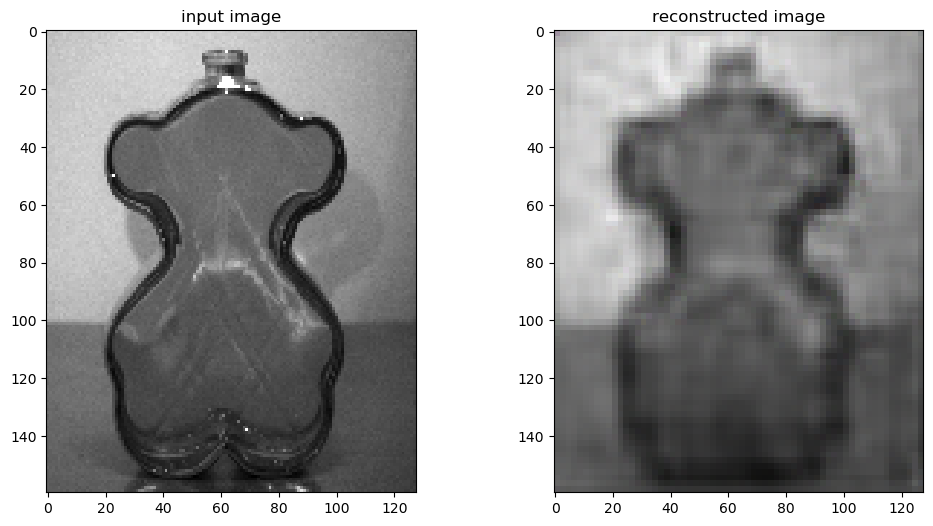

In [37]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

# Quantifying the reconstruction error using "evaluate_generator()" function

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [38]:
validation_error = model.evaluate_generator(val_crops, steps=len(validation_generator))
print("Recon. error for the validation (normal) data is: ", validation_error)




Instructions for updating:
Please use Model.evaluate, which supports generators.
Recon. error for the validation (normal) data is:  0.006012328900396824


This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [39]:
anomaly_error = model.evaluate_generator(anomaly_crops, steps=len(anomaly_generator))
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the anomaly data is:  0.010586066171526909


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [40]:

training_error = model.evaluate_generator(train_crops, steps=len(train_generator))
print("Recon. error for the training (non-anomaly) data is: ", training_error)



Recon. error for the training (non-anomaly) data is:  0.006388398353010416


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

Also see tha the error from the anomaly images is smaller than the error of the training set, which consists of non-anomaly images. THis is not expected and means that this particular model is shit.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [41]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [42]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = next(train_crops)
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")


1/1 [==============================] - 0s 580us/step - loss: 0.0064
The list of rec. error contains  30 batches of rec. errors


In [43]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))


295


In [44]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.008074111950788963
The standard deviation of the errors list is:  0.0023225193850655696
The min value of the errors list is:  0.005008947104215622
The max value of the errors list is:  0.019989702850580215


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [45]:
# anomaly_batch = anomaly_generator.next()

# train_crops
# val_crops
# anomaly_crops
# test_crops

In [46]:
total_rec_error_anomalies = []
for i in range(len(anomaly_generator)):        #I think this should be the correct while clause
    data = next(anomaly_crops)
    total_rec_error_anomalies.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_anomalies), "batches of rec. errors")


1/1 [==============================] - 0s 709us/step - loss: 0.0112
The list of rec. error for anomalies contains  1 batches of rec. errors


In [47]:
total_rec_error_anomalies = [item for sublist in total_rec_error_anomalies for item in sublist]
print(len(total_rec_error_anomalies))

10


In [48]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.010849869623780251
The standard deviation of the errors list is:  0.005040606974931865
The min value of the errors list is:  0.006615470163524151
The max value of the errors list is:  0.024593595415353775


Compute the average and std dev. of recon. error for the validation (non-anomalies) samples. 


In [49]:
total_rec_error_validation = []
for i in range(len(validation_generator)):        #I think this should be the correct while clause
    data = next(val_crops)
    total_rec_error_validation.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_validation), "batches of rec. errors")

# train_crops
# val_crops
# anomaly_crops
# test_crops


1/1 [==============================] - 0s 622us/step - loss: 0.0093
The list of rec. error for anomalies contains  2 batches of rec. errors


In [50]:
total_rec_error_validation = [item for sublist in total_rec_error_validation for item in sublist]
print(len(total_rec_error_validation))

20


In [51]:
val_average_recon_error = np.mean(np.array(total_rec_error_validation))  
val_stdev_recon_error = np.std(np.array(total_rec_error_validation)) 
min_prob = np.min(total_rec_error_validation)
max_prob = np.max(total_rec_error_validation)
print("THIS IS FOR THE VALIDATION IMAGES\n")
print("The average of the errors list is: ", val_average_recon_error)
print("The standard deviation of the errors list is: ", val_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE VALIDATION IMAGES

The average of the errors list is:  0.007334266905672848
The standard deviation of the errors list is:  0.0025417532123913384
The min value of the errors list is:  0.004908782429993153
The max value of the errors list is:  0.016770023852586746


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

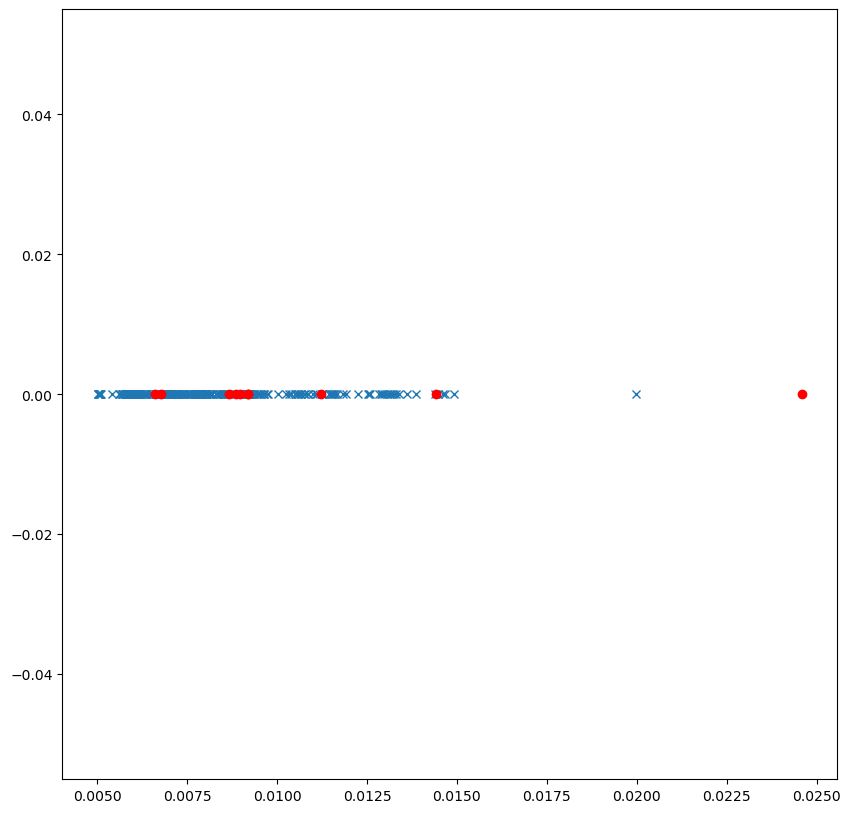

In [52]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

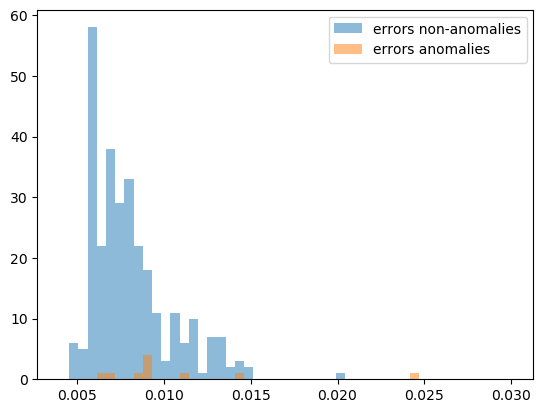

In [53]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0.004, 0.03, 50)

pyplot.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
pyplot.hist(total_rec_error_anomalies, bins, alpha=0.5, label='errors anomalies')
pyplot.legend(loc='upper right')
pyplot.show()

## Checking the latent space

Let's update the weights of the encoder model.

In [54]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [55]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_crops, steps=len(train_generator))



Instructions for updating:
Please use Model.predict, which supports generators.


In [56]:
print(encoded_images.shape)

(295, 40)


See that it is 179 length because it corresponds to all the images that belong to the training dataset. The second length corresponds to the output shape of the model as specified in its structure at the beginning.

In [57]:
type(encoded_images)

numpy.ndarray

In [58]:
encoder_output_shape = encoder.output_shape 
print(encoder_output_shape)

(None, 40)


Now, let's fit KDE to the image latent data

In [59]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

Here below, it is shown the kde values corresponding to each encoded sample. THese are supposed to be very close to each other in value.

In [60]:
density_vals = kde.score_samples(encoded_images)
print(density_vals)

[23.46906363 23.52895778 23.11881361 23.08182259 23.13659423 23.69640756
 24.19120734 24.13516045 24.1850944  24.1054728  24.16551718 24.27459491
 24.28262978 24.26597292 23.41954337 23.41858107 23.14963577 22.36274271
 23.24481226 23.95702483 23.70999706 23.79304748 22.85613366 22.3678743
 22.68320106 23.11496159 23.23733856 22.66244337 22.75884113 22.75775827
 22.90116221 22.37177022 22.61280793 22.30420095 22.3266094  23.09314945
 23.30277673 23.15571924 23.22310338 22.70076512 22.23962    24.00980736
 24.10526205 24.07595036 24.17966683 24.22684113 23.36434627 22.96949533
 22.95618832 22.30078583 22.08909893 23.23879171 24.03187547 24.05737211
 23.4147158  23.27593334 22.9538671  22.580274   22.71699635 22.09483691
 22.48690156 22.16737613 22.01997766 23.11018616 22.8646479  23.14336423
 23.15491763 22.80960299 21.93505329 23.31363925 23.61315771 23.24125421
 23.28714206 23.18292978 22.99695699 22.3259841  22.7659724  22.81315727
 22.55426738 21.9346838  21.94441426 23.65471255 22.

From here, the mean and standard deviation of these values are computed

In [61]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  22.97975066013292
The stdev_density of the density values is:  0.6537864685675949


based on the above data create a function that outputs a probability of a KDE value to be considered an anomaly or non-anomaly image

In [62]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [63]:
# def map_kde2prob_list(input_list):
#     threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score_list = []
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     for i in range (len(input_list)):
#         aux_score = input_list[i] - threshold
#         if aux_score>=0:
#             additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#             prob_score_tot = prob_score+additional
#         else:
#             additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#             prob_score_tot = prob_score-additional
#         if prob_score_tot > 100:
#             prob_score_tot = 100
#         if prob_score_tot < 0:
#             prob_score_tot = 0
#         prob_score_list.append(prob_score_tot)
#     return prob_score_list

In [64]:
# def map_kde2prob(value):
#     threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     aux_score = value - threshold
#     print("value is: ", value)
#     print("aux_score is: ", aux_score)
        
#     if aux_score>=0:
#         additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#         print("additional is: ", additional)
#         prob_score_tot = prob_score+additional
#         print("prob_score_tot is: ", prob_score_tot)
        
#     else:
#         additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#         prob_score_tot = prob_score-additional
#     if prob_score_tot > 100:
#         prob_score_tot = 100
#     if prob_score_tot < 0:
#         prob_score_tot = 0    
#     return prob_score_tot

In [65]:
def map_kde2prob_list(input_list):
    threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
    prob_score_list =[]
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100     
        prob_score_list.append(prob_score)
    return prob_score_list

In [66]:
def map_kde2prob(value):
    threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
    
    aux_score = value - threshold
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
            prob_score = 0
    if prob_score>100:
        prob_score = 100 
    return prob_score

In [67]:
def computePred_kde(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [68]:
print(map_kde2prob_list([average_density - 1*stdev_density]))

[50.00000000000006]


In [69]:
y_pred_kde_final = []
ground_truth = []
y_prob_kde_final = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_crops)
    y_pred_kde = []
    y_true = []
    y_prob_kde = []
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_image_test_set = encoder.predict([[img]])
        densityValue_test = kde.score_samples(encoded_image_test_set)
        prob_kde_test = map_kde2prob(densityValue_test)
        prediction = computePred_kde(densityValue_test)  
        y_pred_kde.append(prediction) # Save Prediction
        y_true.append(labels[im])
        # y_true.append(labels[im]) # Save Truth  
        y_prob_kde.append(prob_kde_test) # Save probability  

    y_pred_kde_final.append(y_pred_kde)  
    ground_truth.append(y_true)  
    y_prob_kde_final.append(y_prob_kde)  
print(ground_truth)
print(y_pred_kde_final)
print(y_prob_kde_final)



[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[0, 1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[[1.6377472918772964, 60.50483048449629, 79.85394838458359, 71.42644374050897, 16.483174366151143, 100, 100, 100, 77.41613511163008, 100], [100, 61.132997313360136, 66.45052723995991, 95.04938009397299, 49.12460118928082, 7.001407064648843, 100, 68.07574152743044, 18.895672496511782, 6.441995010677751], [100, 100, 100, 100, 100, 100, 74.49570813712371, 100, 100, 100]]


In [70]:
ground_truth = [item for sublist in ground_truth for item in sublist]
ground_truth = [int(i) for i in ground_truth]
y_pred_kde_final = [item for sublist in y_pred_kde_final for item in sublist]
y_prob_kde_final = [item for sublist in y_prob_kde_final for item in sublist]
print(ground_truth)
print(y_pred_kde_final)
print(y_prob_kde_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.6377472918772964, 60.50483048449629, 79.85394838458359, 71.42644374050897, 16.483174366151143, 100, 100, 100, 77.41613511163008, 100, 100, 61.132997313360136, 66.45052723995991, 95.04938009397299, 49.12460118928082, 7.001407064648843, 100, 68.07574152743044, 18.895672496511782, 6.441995010677751, 100, 100, 100, 100, 100, 100, 74.49570813712371, 100, 100, 100]


Below commented section is just another way of computing the predicions and probabilitis shown above. THis approach computes separately the labels of the test set and their probabilities 

In [71]:
# ground_truth = []
# for i in range(len(test_set_generator)):        #I think this should be the correct while clause
#     _, labels = next(test_crops)
#     ground_truth.append(labels)
    
# print("The list of rec. error for anomalies contains ", len(ground_truth), "batches of rec. errors")

# print(ground_truth)
# #Get encoded output of input images = Latent space
# encoded_images_test_set = encoder.predict_generator(test_crops, steps=len(test_set_generator))
# print(encoded_images_test_set.shape)

# density_vals_test = kde.score_samples(encoded_images_test_set)
# print(density_vals_test)

# average_density + stdev_density
# average_density - stdev_density

# prob_test = map_kde2prob_list(density_vals_test)
# print(prob_test)

# ground_truth = [item for sublist in ground_truth for item in sublist]
# ground_truth = [int(x) for x in ground_truth]

# pred_list =[]
# for i in range(len(prob_test)):
    
#     if(prob_test[i]>50):
#         pred = 1
#     else:
#         pred = 0
#     pred_list.append(pred)
# print(ground_truth)
# print(pred_list)

In [72]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(ground_truth, y_prob_kde_final))

AUC =  0.8200000000000001


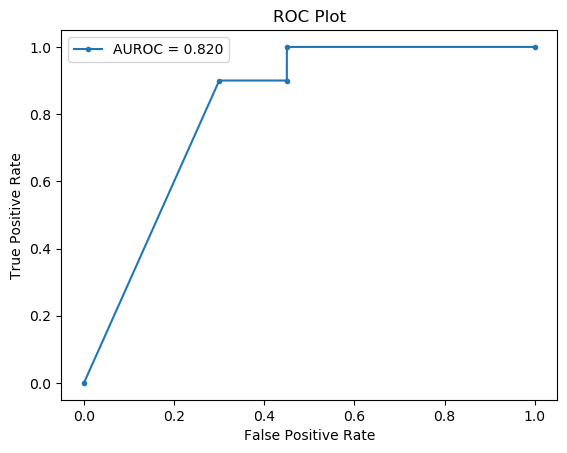

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(ground_truth, y_prob_kde_final)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(ground_truth, y_prob_kde_final))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [74]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.3  0.45 0.45 1.  ]
The tpr is:  [0.  0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          77.41613511  74.49570814   1.63774729]


FRom above we can see that the results are not that good; these could be improved. HOwever these results are not as bad as the previous programs. 

FRom the above graph, it is seen that the best threshold could be:  1.63774259. Let's see if we obtain what we expect (FPR = 0.45 and TPR = 1.0).

- NOTE: Notice, that it was previously accorded that the thresholds shown by the metrics.roc_auc_score(ground_truth, prob_test) functions were going to be considered as 100-x to effectively test the FPR and TPR values. However in this case, strangely, see that directly using the threshold displayed by the function is used. It is not known yet why this happens. 

In [75]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [76]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [77]:
conf_matrix = confusion_matrix(ground_truth, pred_label_onProb(y_prob_kde_final, (74.49570045)))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 74.49570045")

[[11  9]
 [ 0 10]]
The FPR values are:  0.45
The TPR values are:  1.0
Using the threshold = 74.49570045


Actually, the threshold= 74.49570045 is the one that corresonds to FPR = 0.45 and TPR = 1.0

## Trehshold based on Gaussian distribution of the non-anomaly images

In [78]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

See below test, that shows if a reconstruction error is equal to the mean of the reconstruction error plus its standard deviation has 50% chance of being predicted as anomaly image.

In [79]:
print(map_error2prob(na_average_recon_error + na_stdev_recon_error))

50.000000000000014


In [80]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

In [81]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    else:
        pred =0 
    return pred

In [82]:
y_pred_final = []
y_true_final = []
y_prob_final = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_crops)
    y_pred = []
    y_true = []
    y_prob = []
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        probability = map_error2prob(reconstruction_error)
        prediction = computePred(reconstruction_error)   
        y_pred.append(prediction) # Save Prediction
        y_true.append(labels[im]) # Save Truth  
        y_prob.append(probability) # Save probability  
    y_pred_final.append(y_pred)  
    y_true_final.append(y_true)  
    y_prob_final.append(y_prob)  
print(y_true_final)
print(y_pred_final)
print(y_prob_final)


# train_crops
# val_crops
# anomaly_crops
# test_crops
 

1/1 [==============================] - 0s 683us/step - loss: 0.0104
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 0, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 1]]
[[9.861434654330274, 0.529261625780871, 2.371989490971472, 35.903645352763526, 17.279131485798025, 26.87328795052074, 35.628962623433544, 49.59421352942074, 100, 100], [100, 12.480205933071959, 67.62202200219836, 4.69368009867181, 9.20847397890652, 49.84950579217801, 97.85795400629014, 62.660918811388086, 26.910269869809, 23.528494400320376], [30.39430951892883, 23.40131055355245, 15.333335170760357, 85.95087873635482, 20.649338200919978, 100, 27.61746990059084, 20.77845913353933, 9.826911116584133, 50.803198485323556]]


In [83]:
y_true_final = [item for sublist in y_true_final for item in sublist]
y_true_final = [int(i) for i in y_true_final]
y_pred_final = [item for sublist in y_pred_final for item in sublist]
y_prob_final = [item for sublist in y_prob_final for item in sublist]
print(y_true_final)
print(y_pred_final)
print(y_prob_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[9.861434654330274, 0.529261625780871, 2.371989490971472, 35.903645352763526, 17.279131485798025, 26.87328795052074, 35.628962623433544, 49.59421352942074, 100, 100, 100, 12.480205933071959, 67.62202200219836, 4.69368009867181, 9.20847397890652, 49.84950579217801, 97.85795400629014, 62.660918811388086, 26.910269869809, 23.528494400320376, 30.39430951892883, 23.40131055355245, 15.333335170760357, 85.95087873635482, 20.649338200919978, 100, 27.61746990059084, 20.77845913353933, 9.826911116584133, 50.803198485323556]


Above we see the predictions based on a threshold of 50%. See that the results are not that good. There are some false positive results and more important there are a considerable number of false negatives.

AUC =  0.4975


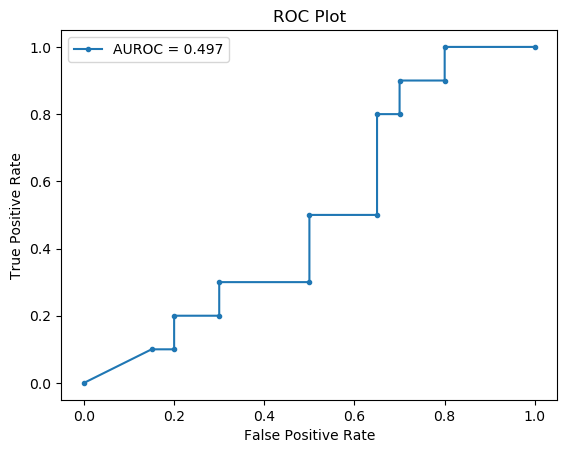

The fpr is:  [0.   0.15 0.2  0.2  0.3  0.3  0.5  0.5  0.65 0.65 0.7  0.7  0.8  0.8
 1.  ]
The tpr is:  [0.  0.1 0.1 0.2 0.2 0.3 0.3 0.5 0.5 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          97.85795401  85.95087874  62.66091881
  50.80319849  35.62896262  27.6174699   23.5284944   20.6493382
  17.27913149  15.33333517   9.86143465   9.82691112   0.52926163]


In [84]:
print('AUC = ', metrics.roc_auc_score(y_true_final, y_prob_final))
fpr, tpr, thresholds = metrics.roc_curve(y_true_final, y_prob_final)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true_final, y_prob_final))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

At this point, the graph above shows us that there is not any acceptable threshold to work with. The result from the reconstruction error are poor in this approach.

## Verifying the evaluation set

In [85]:
#Just to test the model. 
data_batch_test = []  #Capture all training batches as a numpy array
labels_test = []
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(test_set_generator):        #I think this should be the correct while clause
    data, labels = next(test_crops)
    data_batch_test.append(data)
    labels_test.append(labels)
    img_num = img_num + 1
    
print("number of batches are: ", img_num)

number of batches are:  3


In [86]:
index_batch = 2
print(data_batch_test[index_batch].shape)
predicted_fromTestSet = model.predict(data_batch_test[index_batch])  
print(predicted_fromTestSet.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


In [87]:
single_img = data_batch_test[index_batch][0]
print(single_img.shape)

(160, 128, 3)


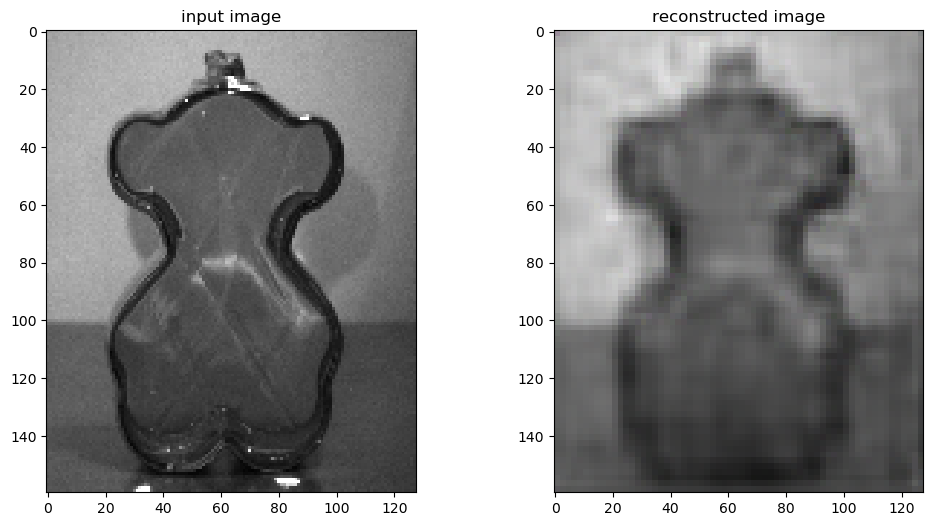

In [88]:
#Sanity check, view few images and corresponding reconstructions
image_number = 0
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch_test[index_batch][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted_fromTestSet[image_number])
plt.show()

Displaying the label of this particular image.

In [89]:
print(labels_test[index_batch][image_number])

1.0


## Analyzing further the results of the reconstruction images

See below images. THe first one is predicted to be an anomaly while the second one is predicted be a non-anomaly image.

1/1 [==============================] - 0s 830us/step - loss: 0.0133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


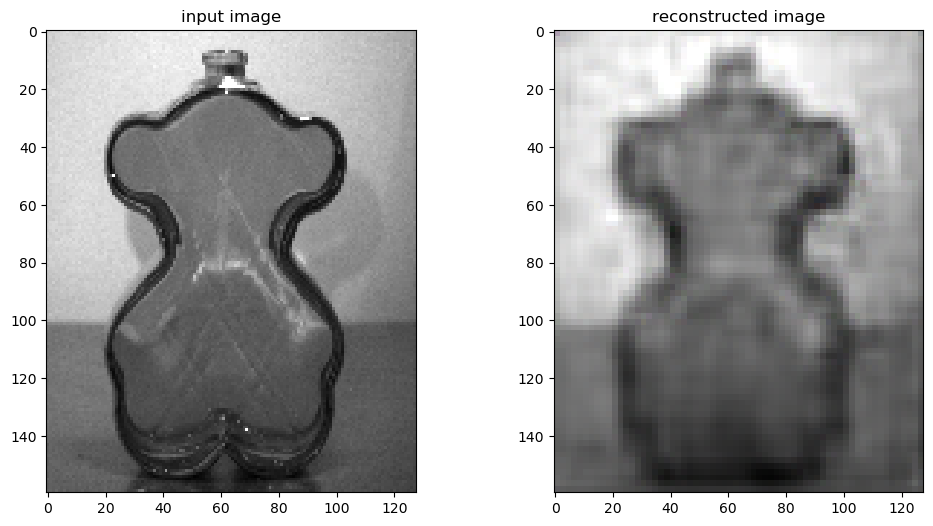

The label image is:  0.0
Its probability is:  100
Its prediction is:  1
Its reconstruction_error is:  0.01332825142890215


In [101]:

for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_crops)
    if i == 0:
        for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
            if im == batch_images.shape[0]-1:
                img  = batch_images[im]

                label_img = labels[im]

                img = img[np.newaxis, :,:,:]
                reconstruction = model.predict([[img]])

                reconstruction_error = model.evaluate([reconstruction],[[img]])
                probability = map_error2prob(reconstruction_error)
                prediction = computePred(reconstruction_error)   

                

to_print_original = img[0]
to_print_reconstruction = reconstruction[0]
#Sanity check, view few images and corresponding reconstructions
image_number = 0
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(to_print_original)
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(to_print_reconstruction)
plt.show()

print("The label image is: ", label_img)
print("Its probability is: ", probability)
print("Its prediction is: ", prediction)
print("Its reconstruction_error is: ", reconstruction_error)


1/1 [==============================] - 0s 617us/step - loss: 0.0076


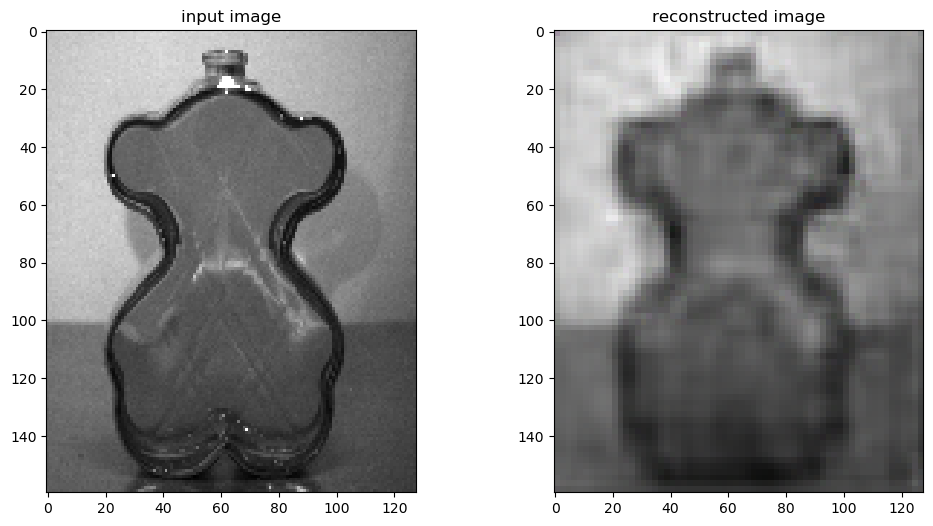

The label image is:  0.0
Its probability is:  9.861434654330274
Its prediction is:  0
Its reconstruction_error is:  0.007616044487804174


In [106]:

for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_crops)
    if i == 0:
        for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
            if im == 0:
                img  = batch_images[im]

                label_img = labels[im]

                img = img[np.newaxis, :,:,:]
                reconstruction = model.predict([[img]])

                reconstruction_error = model.evaluate([reconstruction],[[img]])
                probability = map_error2prob(reconstruction_error)
                prediction = computePred(reconstruction_error)   

                

to_print_original = img[0]
to_print_reconstruction = reconstruction[0]
#Sanity check, view few images and corresponding reconstructions
image_number = 0
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(to_print_original)
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(to_print_reconstruction)
plt.show()

print("The label image is: ", label_img)
print("Its probability is: ", probability)
print("Its prediction is: ", prediction)
print("Its reconstruction_error is: ", reconstruction_error)


In [102]:
na_average_recon_error + na_stdev_recon_error

0.010396631335854533

In [103]:
na_average_recon_error - na_stdev_recon_error

0.005751592565723393

In [105]:
print(na_average_recon_error)
print(na_stdev_recon_error)

0.008074111950788963
0.0023225193850655696


As seen above both images at simple look, seem to be the same. However, the first image seems to have more brightness, perhaps that's what made it to be predicted as anomaly.